## Common parts

### Imports

#### Ensure all libraries are installed /w "requirements.txt"

In [411]:
# Common libs
import numpy as np
import time
import pandas as pd
import skfuzzy as fuzz
from IPython.display import display, HTML
import seaborn as sns
import matplotlib.pyplot as plt

In [368]:
# Selfmade functions
import sm_libs.data_loading as dl
import sm_libs.knn_core as knnc

### Re-usable Functions

In [369]:
def run_knn(np_file_data, col_masks, np_compare_data, k = 10):

    # ---------------- Run C++-Accelerated k-NN ----------------
    neighbors_per_file = []

    for i in range(len(np_file_data)):
        print(f"Processing file {i} using C++ module...", flush=True)

        neighbors = knnc.knn_for_file(
            np_file_data[i],   # NumPy 2D array for file i
            i,                 # Index of current file
            np_compare_data,      # List of all NumPy arrays
            col_masks,      # List of lists of global attribute indices
            k,
            len(all_attrs)     # Total number of global attributes
        )

        neighbors_per_file.append(neighbors)

    print(f"C++ k-NN completed.")
    return neighbors_per_file

In [370]:
def impute(np_neighbors):
    # ---------------- Data postprocessing ----------------
    imputed_file_data_list = []

    for file_idx, file_rows in enumerate(file_data):
        imputed_rows = []
        neighbors_per_row = np_neighbors[file_idx]

        for row_idx, row in enumerate(file_rows):
            row_dict = row.copy()
            neighbors = neighbors_per_row[row_idx]

            missing_attrs = [attr for attr in all_attrs if attr not in row_dict]

            for missing_attr in missing_attrs:
                values = []

                for dist, n_file_idx, n_row_idx in neighbors:
                    neighbor_row = file_data[n_file_idx][n_row_idx]
                    if missing_attr in neighbor_row:
                        values.append(neighbor_row[missing_attr])

                if values:
                    imputed_value = np.mean(values)
                    row_dict[missing_attr] = imputed_value
                else:
                    # Leave missing if no neighbor has the value
                    row_dict[missing_attr] = np.nan

            imputed_rows.append(row_dict)

        imputed_file_data_list.append(imputed_rows)

    return imputed_file_data_list

In [371]:
def print_table(imputed_list):
    for f_idx, f_rows in enumerate(imputed_list):
        df = pd.DataFrame(f_rows)

        # Sort columns numerically if possible
        sorted_cols = sorted(
            df.columns,
            key=lambda x: int(x) if str(x).isdigit() else float("inf")
        )

        df_result = df[sorted_cols]  # Reorder columns

        # Display with heading
        display(HTML(f"<h4>File {f_idx} – {len(df_result)} rows</h4>"))
        display(df_result.reset_index(drop=True))  # Remove left index

In [372]:
def calculate_fcm_clusters(np_file_data, n_clusters=2, m=2.0, error=0.005, maxiter=1000):
    """
    Calculate fuzzy c-means cluster centers for each file's data.
    Returns list of numpy arrays with cluster centers per file.
    """
    cluster_centers_list = []
    for i, data in enumerate(np_file_data):
        if data.shape[0] < n_clusters:
            # Not enough data points for requested clusters — just use the data as centers
            cluster_centers_list.append(data)
            continue

        # Transpose data to shape (features, samples) for skfuzzy
        data_T = data.T

        # Run fuzzy c-means
        cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
            data_T, c=n_clusters, m=m, error=error, maxiter=maxiter, init=None
        )
        # cntr shape = (n_clusters, n_features)
        cluster_centers_list.append(cntr)
    return cluster_centers_list

### Data Loading

In [373]:
# ---------------- Configuration ----------------
data_type = 'duze'
data_ver = 1
full_base_path = f'../dane/{data_type}/{data_ver}'

print(f"Loading data from: {full_base_path}")
file_data, all_attrs = dl.load_files(full_base_path, data_type)
all_attrs = sorted([str(attr) for attr in all_attrs])  # Ensure string consistency

print(f"Loaded {len(file_data)} files")
for i, file_rows in enumerate(file_data):
    print(f"  File {i}: {len(file_rows)} rows")
print(f"Total attributes: {len(all_attrs)}")

Loading data from: ../dane/duze/1
Loaded 10 files
  File 0: 7888 rows
  File 1: 7816 rows
  File 2: 6463 rows
  File 3: 5128 rows
  File 4: 5423 rows
  File 5: 6594 rows
  File 6: 6044 rows
  File 7: 6700 rows
  File 8: 7552 rows
  File 9: 6281 rows
Total attributes: 17


### Data Preprocessing

In [374]:
# ---------------- Prepare Data for C++ ----------------

# Map: attribute name → index
attr_to_index = {attr: idx for idx, attr in enumerate(all_attrs)}

# Convert file rows (list of dicts) → numpy arrays with shared attr ordering
np_common_file_data = []
column_masks = []

for file_rows in file_data:
    # Find present attributes in this file
    present_attrs = [attr for attr in all_attrs if attr in file_rows[0]]
    column_masks.append([attr_to_index[attr] for attr in present_attrs])

    # Create numpy array for this file
    rows = []
    for row in file_rows:
        row_values = [row[attr] for attr in present_attrs]
        rows.append(row_values)

    np_array = np.array(rows, dtype=np.float64)
    np_common_file_data.append(np_array)

# Pure KNN

In [375]:
# Deep copy numpy arrays inside the list
np_pureKNN_file_data = [arr.copy() for arr in np_common_file_data]

In [376]:
# ---------------- Calculate k-NN ----------------
print("Calculating k-NN...")

pureKNN_KNN_duration = time.time()
np_pureKNN_neighbors = run_knn(np_pureKNN_file_data, column_masks, np_pureKNN_file_data)
pureKNN_KNN_duration = time.time() - pureKNN_KNN_duration

print(f"Calculating k-NN took: {pureKNN_KNN_duration:.2f} seconds.")

Calculating k-NN...
Processing file 0 using C++ module...
Processing file 1 using C++ module...
Processing file 2 using C++ module...
Processing file 3 using C++ module...
Processing file 4 using C++ module...
Processing file 5 using C++ module...
Processing file 6 using C++ module...
Processing file 7 using C++ module...
Processing file 8 using C++ module...
Processing file 9 using C++ module...
C++ k-NN completed.
Calculating k-NN took: 159.23 seconds.


In [377]:
# ---------------- Impute data ----------------
print("Imputing data...")

pureKNN_imputation_duration = time.time()
pureKNN_imputed = impute(np_pureKNN_neighbors)
pureKNN_imputation_duration = time.time() - pureKNN_imputation_duration

print("\nImputed data preview for the first file:")

preview_rows = pureKNN_imputed[1][:10]
print(preview_rows)

print(f"Imputation took: {pureKNN_imputation_duration:.2f} seconds.")

Imputing data...

Imputed data preview for the first file:
[{'0': 4.84038, '3': 3.02869, '4': 0.239666, '6': 0.0488068, '7': 0.00299133, '8': 2.09979, '9': 40.317, '10': 3.0525, '11': 0.459937, '12': 172.664, '14': 4.02054, '15': 2.62657, '1': nan, '13': 140.7594, '16': 1.901851, '2': 8.90317, '5': 6.9854189999999985}, {'0': 11.4375, '3': 3.16232, '4': 0.352491, '6': 0.0493689, '7': 0.00292049, '8': 2.05713, '9': 40.4432, '10': 3.1351, '11': 6.46077, '12': 189.453, '14': 6.89141, '15': 2.55419, '1': 0.9595373333333334, '13': 142.3236, '16': 0.8936643999999999, '2': 4.926035714285716, '5': 3.015109}, {'0': 3.43328, '3': 8.30775, '4': 0.901191, '6': 0.0298853, '7': 0.0100217, '8': 3.04757, '9': 41.8146, '10': 4.06459, '11': 7.25826, '12': 216.431, '14': 9.42478, '15': 4.41587, '1': nan, '13': 168.3818, '16': 2.732917, '2': 2.482863, '5': 6.018627}, {'0': 3.47715, '3': 3.3805, '4': 2.43171, '6': 1.06505, '7': 0.00609244, '8': 2.69146, '9': 47.8504, '10': 4.03641, '11': 7.0258, '12': 240.3

In [378]:
print_table(pureKNN_imputed)

pureKNN_total_duration = pureKNN_KNN_duration + pureKNN_imputation_duration
print(f"Total pure k-NN took: { pureKNN_total_duration:.2f} seconds.")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,3.350733,1.666010,2.51232,8.39050,1.150690,5.967370,0.029354,0.009957,2.84841,41.5645,3.89550,6.77960,233.522800,161.440,9.415430,4.520283,2.384190
1,3.949583,1.078350,9.25038,3.02807,0.237986,7.044580,0.051256,0.002860,1.99231,38.9407,2.96491,1.15217,196.632778,141.780,3.998770,2.512146,1.901350
2,4.148410,1.021660,8.72897,2.99291,0.090507,7.088165,0.049396,0.002914,1.59997,42.7964,2.93290,2.51005,195.443714,148.369,3.928700,2.505157,1.896810
3,4.102430,1.274130,1.47564,2.11190,0.349528,5.352164,0.027533,0.006040,4.90712,42.4476,4.20593,4.59337,232.440222,164.434,5.496760,3.495385,0.340892
4,2.944202,2.152350,7.90424,6.39727,0.844579,0.960187,0.200882,0.005044,3.08559,40.8261,2.93797,5.66530,203.179667,130.984,1.011610,6.495937,1.518340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7883,3.458237,1.454230,5.90067,3.40713,2.127260,5.374915,1.070420,0.005998,2.51874,44.1582,4.09365,7.08064,239.714375,171.871,12.132900,3.487239,1.754800
7884,3.051906,2.325780,7.39412,6.31952,0.741474,0.997165,0.199752,0.004929,2.60434,40.5748,2.93340,4.75360,197.880667,139.428,0.959101,6.486822,1.486350
7885,3.847157,0.981022,8.83619,2.93794,0.213116,7.007011,0.050851,0.003082,2.09385,40.9310,2.99524,4.60853,198.460444,129.341,4.079300,2.452838,1.900810
7886,3.970354,1.102750,8.79556,3.09835,0.276393,6.944388,0.051007,0.002897,2.28175,38.7168,2.91616,1.49868,206.229222,142.251,4.026210,2.483969,1.903180


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,4.84038,NaN,8.903170,3.02869,0.239666,6.985419,0.048807,0.002991,2.09979,40.3170,3.05250,0.459937,172.664,140.7594,4.02054,2.62657,1.901851
1,11.43750,0.959537,4.926036,3.16232,0.352491,3.015109,0.049369,0.002920,2.05713,40.4432,3.13510,6.460770,189.453,142.3236,6.89141,2.55419,0.893664
2,3.43328,NaN,2.482863,8.30775,0.901191,6.018627,0.029885,0.010022,3.04757,41.8146,4.06459,7.258260,216.431,168.3818,9.42478,4.41587,2.732917
3,3.47715,1.782840,5.577619,3.38050,2.431710,5.272646,1.065050,0.006092,2.69146,47.8504,4.03641,7.025800,240.365,172.5966,11.97370,3.54874,1.851904
4,3.42431,2.063160,2.460147,8.50721,0.879097,6.051320,0.032368,0.009518,2.87997,43.5889,3.94057,6.308240,216.764,161.3912,9.51658,4.51532,2.653509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7811,4.20150,1.638225,1.343834,2.44864,0.306999,5.239336,0.029513,0.006099,4.44764,41.7354,4.20508,6.294550,219.735,166.5134,5.58153,3.44768,0.371507
7812,3.70578,1.653900,2.550432,8.28953,0.908873,5.993961,0.031028,0.009776,2.34107,41.6429,4.24417,6.185730,217.967,163.8165,9.51779,4.60432,2.830692
7813,3.54130,NaN,5.505240,3.34258,2.180420,5.375332,1.068430,0.005788,2.76204,46.3045,3.90576,7.816170,241.260,170.5580,12.08720,3.49095,1.838427
7814,11.21760,1.195560,5.082162,3.01607,0.191839,3.012625,0.048875,0.002972,1.85773,41.0488,3.02337,5.909210,213.979,139.4192,6.80187,2.53873,0.900894


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,3.65638,1.62526,5.502621,3.434428,2.291000,5.35967,1.067320,0.006105,2.86673,47.9436,4.17616,6.046209,241.665889,180.939,11.941750,3.54530,1.942190
1,3.60863,2.35243,2.377900,8.370886,0.880133,5.98546,0.031086,0.010065,2.83787,41.5331,4.11255,6.005364,226.186333,171.762,9.522853,4.50500,2.816370
2,6.38161,2.08846,5.390865,3.472935,1.221670,2.77419,0.032261,0.003312,2.30100,46.7149,4.15993,5.833600,223.916400,160.503,5.098068,1.28930,1.478090
3,3.14040,2.18666,6.828466,6.390313,0.853424,1.11480,0.200121,0.006037,2.73821,40.3760,2.86566,4.900037,201.793000,143.182,1.850937,6.75011,1.501230
4,4.02849,1.51106,1.552873,2.367150,0.180420,5.58368,0.024962,0.005940,5.05512,42.9976,4.00919,5.658944,229.940700,158.393,5.484909,3.60090,0.140132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6458,3.51409,1.44504,5.664833,3.400150,2.246800,5.30942,1.072730,0.005900,2.76917,47.5201,4.19158,6.554949,240.656400,163.295,11.993490,3.42219,1.432450
6459,11.36030,1.01429,5.038742,2.987493,0.305842,3.00218,0.050228,0.003103,2.23612,41.3004,2.92388,5.278449,200.564571,143.442,7.040605,2.37636,0.910025
6460,11.07150,1.16439,4.974743,2.910047,0.220503,2.97578,0.050205,0.003037,1.74902,40.7207,2.93546,4.820876,204.285778,139.555,6.998616,2.52775,0.911762
6461,3.02615,2.05107,7.407046,6.430345,0.719424,1.01861,0.201262,0.004894,2.50123,40.3359,2.99895,4.079285,202.857200,140.109,0.955145,6.56380,1.499520


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,3.03790,2.323400,7.578960,6.20434,0.855720,0.869235,0.199064,0.005102,2.96946,39.404925,3.018782,3.26735,209.756,144.165,1.05061,6.51786,1.503656
1,11.47200,0.895736,4.955954,2.93808,0.244758,3.035920,0.049836,0.003094,2.14365,39.814300,3.005811,3.36612,189.428,139.359,7.15199,2.46287,0.896999
2,6.35181,2.192280,5.503566,3.36528,1.142665,2.750340,0.028982,0.003513,2.70049,47.880729,4.062510,6.08422,224.348,168.289,5.14128,1.40966,1.607558
3,3.43956,1.203620,5.554673,3.41218,2.278447,5.335140,1.074210,0.006012,2.97982,47.066600,4.021953,7.66572,235.220,175.814,12.01630,3.39295,1.831610
4,10.64230,1.085860,5.057564,3.11557,0.205300,3.107080,0.050811,0.002726,1.93297,40.028600,2.992181,4.75881,200.516,142.358,7.05904,2.46659,0.895720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5123,3.10193,2.061130,7.606481,6.36216,0.748276,0.829424,0.199626,0.005080,2.67539,40.325660,2.945570,3.46325,204.437,134.566,1.06842,6.50465,1.499198
5124,11.35340,1.037520,5.065117,3.07818,0.201644,2.997160,0.049894,0.002946,1.95289,39.252183,3.001498,4.41257,195.653,132.888,7.07044,2.40770,0.893342
5125,5.68506,1.674510,7.622565,3.46573,0.759764,3.135640,NaN,0.003095,3.32968,64.790571,1.086402,6.30486,230.562,172.438,7.63911,8.80769,3.715615
5126,4.14921,1.098290,9.008452,2.79139,0.192209,6.946020,0.048483,0.003107,2.13743,40.107380,2.989903,3.91194,209.475,138.053,4.01370,2.71520,1.900118


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,2.96026,2.382510,7.41876,6.46672,0.810666,1.006591,0.200943,0.005087,2.70730,39.70992,2.952461,5.24460,196.613800,130.801,0.945804,6.482201,NaN
1,3.95920,1.132020,9.06645,2.78885,0.157862,7.004148,0.049643,0.002879,2.08401,39.56277,3.018588,2.91816,195.314900,150.009,3.986540,2.495713,1.881170
2,5.45844,2.032300,7.62362,3.29945,0.899747,3.074142,0.499579,0.002932,2.89723,65.02379,1.094547,6.09290,226.168889,164.021,7.617220,8.472432,3.766265
3,6.56254,1.956320,6.24615,3.61676,1.277880,2.925909,0.030787,0.002368,2.75136,47.88568,4.055453,5.14217,227.887400,157.448,4.979490,1.315292,NaN
4,4.07447,1.445800,1.58737,2.23133,0.320011,5.293728,0.031067,0.006062,4.97865,41.55661,4.101133,4.79222,224.277222,160.448,5.483780,3.510464,0.514048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5418,10.92190,0.821039,4.73318,2.74420,0.130111,2.994963,NaN,0.002903,2.16829,39.92619,2.962814,5.65048,198.380700,139.376,7.047210,2.522464,NaN
5419,6.50032,2.080400,5.25999,3.46980,1.126800,2.869096,0.030891,0.002742,2.47739,46.97467,4.119842,6.14403,220.901889,158.070,5.170340,1.325376,1.613980
5420,2.94860,2.215950,7.35850,6.22890,0.947651,1.039221,0.200548,0.004633,2.87398,39.75679,3.006204,4.44691,202.372500,134.061,1.039390,6.496060,NaN
5421,4.14399,1.667320,1.12851,2.34107,0.402125,5.325585,NaN,0.006116,4.36704,41.84290,4.087857,7.17780,229.337500,163.138,5.515310,3.496955,NaN


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,3.504540,NaN,2.66345,8.14937,1.039900,5.902140,0.030053,0.010071,2.52334,39.3584,4.09065,5.29308,219.530,165.706333,9.513210,4.52650,2.38445
1,3.443023,2.005713,2.26285,8.54556,0.999258,5.899740,0.030930,0.010112,2.33472,43.5233,4.21995,6.96481,222.326,164.733556,9.583380,4.63238,2.37234
2,6.546334,1.976510,5.73625,3.31083,1.262920,2.857370,0.029086,NaN,2.58214,49.6220,4.20098,4.51009,217.011,166.055900,5.021390,1.30053,1.55648
3,10.911200,0.973832,5.00175,2.98781,0.224520,2.869770,0.050108,0.002971,1.78667,40.4757,3.01777,6.35058,178.407,138.182300,7.038130,2.55849,0.88482
4,2.961814,2.254156,7.81431,6.50688,0.678810,0.911717,0.200409,0.004976,2.63264,38.8496,3.00751,5.03731,203.899,140.870000,0.865269,6.48259,1.49508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6589,6.539596,1.833460,5.33287,3.21669,1.011360,3.054090,0.031594,0.003140,2.52474,45.6624,3.98205,6.22002,213.262,162.699500,5.080450,1.37474,2.15615
6590,5.384950,2.074458,7.18463,3.46335,0.827610,3.251320,0.499338,0.002865,3.03222,66.7070,1.23253,6.58812,210.951,161.868222,7.515210,8.51158,3.94361
6591,5.586635,1.805515,7.37953,3.24707,0.801893,3.219500,0.499454,0.003210,2.64021,65.2148,1.17425,7.50351,226.454,165.931000,7.352500,8.33431,3.98784
6592,5.378375,1.965304,7.17791,3.30191,0.683739,3.145170,0.498539,0.003252,2.88285,64.7502,1.06010,4.73282,214.598,161.324500,7.418580,8.55364,3.80782


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,3.22197,2.193480,2.34817,NaN,1.068020,6.010551,NaN,0.010143,2.789123,41.8522,4.125454,6.53575,238.067,163.443600,9.555870,NaN,2.698980
1,6.66179,2.082380,5.21683,3.30413,1.242210,2.825687,0.033095,0.003030,2.613689,50.8175,4.111859,5.94322,210.297,166.819444,5.069070,1.203890,1.719803
2,3.56750,1.768940,5.66942,NaN,2.289760,5.256513,NaN,0.006466,3.070316,45.6510,4.056674,5.24360,253.315,169.342900,12.014100,NaN,1.987970
3,3.41418,1.800590,5.91016,NaN,2.308550,5.272847,1.071180,0.005781,3.038154,47.4446,3.983223,8.76692,243.248,169.803700,11.931400,3.502640,1.928003
4,2.84547,2.382170,7.46793,NaN,0.861686,1.005144,0.200474,0.004672,2.742512,40.8511,2.983904,3.19088,190.020,139.929700,0.908376,6.553730,1.505133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6039,6.65452,1.921960,5.72463,3.37257,1.176690,2.899323,0.027946,0.002980,2.562115,46.2164,4.098056,5.24187,229.916,164.780100,5.214620,NaN,1.729882
6040,10.84650,1.041210,5.40663,NaN,0.238267,3.011265,0.050387,0.003150,1.951540,41.2681,2.985746,4.95318,203.982,142.662000,7.072250,2.638030,0.894541
6041,11.01170,0.869743,5.05664,2.92885,0.216911,3.009457,NaN,0.002909,2.055369,40.4710,3.011758,3.79838,196.060,141.047700,7.067470,NaN,0.896733
6042,3.00552,2.111310,8.00460,NaN,0.791596,0.996277,0.199556,0.005471,2.671378,39.7710,2.979254,3.18975,189.724,141.366900,1.175730,6.454752,1.497677


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,10.84090,1.014132,4.70020,2.902882,0.193830,3.06715,0.049895,0.003037,1.889695,40.0219,2.99914,4.830548,219.675,140.9413,7.04779,2.66450,0.898079
1,4.05097,0.990913,8.72645,2.957515,0.262459,7.11627,NaN,0.002967,2.037386,41.6191,2.85135,1.765278,197.291,140.6480,3.96639,2.49669,NaN
2,3.40322,1.524420,5.70916,3.419684,2.199510,5.27484,1.070550,0.005832,2.854229,47.1223,4.14101,5.991327,228.967,171.6072,11.91080,3.57721,1.638610
3,10.54820,0.928558,4.97344,3.054505,0.190524,2.99180,0.050117,0.002777,1.942212,41.0289,3.06101,3.038137,182.101,145.4243,7.12087,2.46087,0.899606
4,4.21134,1.021568,8.99221,3.001404,0.330896,7.11382,0.051136,0.002811,1.933256,39.8172,3.06294,2.539073,197.228,141.8206,3.99744,2.36356,1.900010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6695,4.22549,1.594630,1.61260,2.454590,0.272524,5.27866,NaN,0.006623,4.786250,42.4889,4.19842,6.162647,225.800,166.1379,5.64186,3.47439,0.416815
6696,4.18094,1.405829,1.19273,2.403332,0.266376,5.02595,NaN,0.005540,4.716089,42.7986,4.27911,6.234528,225.099,162.8647,5.51427,3.51456,0.333395
6697,3.45540,1.453496,5.57657,3.357228,2.256930,5.37699,1.070750,0.005607,2.794043,45.1818,4.05492,6.490145,238.040,167.5557,11.76830,3.43593,1.881457
6698,11.55110,1.028004,4.95521,2.966550,0.255637,3.02808,0.050247,0.002968,1.908771,40.3816,3.16960,4.827458,209.903,139.9361,7.05718,2.37033,0.904882


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,3.20475,2.22299,7.637819,6.468940,0.805807,0.993131,0.202087,0.005282,2.627697,39.642340,2.984405,6.45518,184.203,140.825,1.04423,6.52562,1.503460
1,6.79045,1.96660,5.419586,NaN,1.209012,2.863012,0.025853,0.002289,2.654891,50.326700,4.126897,4.16339,212.815,165.039,5.02676,1.31427,1.722153
2,11.68720,1.03098,5.032371,2.990845,0.218872,2.944710,0.049586,0.003182,2.069976,40.657117,3.042481,5.39296,212.918,132.130,7.03639,2.56487,0.895709
3,3.41667,2.05483,2.353343,8.349230,0.959139,5.977958,0.027463,0.009943,2.838705,41.943583,4.092205,6.02244,233.746,156.769,9.38620,4.60468,2.712046
4,6.61213,1.70283,5.441031,3.324470,1.183158,2.950983,0.032054,0.003110,2.504036,50.071950,4.024267,4.46830,224.045,160.261,5.02969,1.45849,1.782363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7547,4.07584,1.89814,1.391429,2.355155,0.297312,5.257278,0.030878,0.006147,4.883420,41.767100,4.036884,5.65785,236.994,166.164,5.61067,3.50933,0.484381
7548,3.43925,1.72593,2.524363,8.267400,0.945148,5.964922,0.029749,0.010194,2.883973,41.401620,4.105038,5.99745,238.392,163.378,9.33870,4.48738,2.635832
7549,5.75825,1.81510,7.490713,NaN,0.824040,3.166968,0.498656,0.002962,3.047536,65.141100,1.116568,7.30013,228.259,164.914,7.41916,8.41698,3.772329
7550,11.32420,1.24377,5.007606,2.885500,0.195624,3.077045,0.049936,NaN,2.019958,40.612400,2.953634,3.99426,189.547,144.250,7.02658,2.43084,0.898321


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,2.955570,2.161473,7.17023,6.469253,0.742397,0.922013,0.199868,0.005034,2.60916,39.974529,2.95121,4.989966,206.191300,142.155,1.133750,6.611205,1.516500
1,3.521301,1.464993,5.54993,3.341840,2.313400,5.246630,1.069938,0.005912,2.98702,46.619320,3.96630,6.130871,239.224300,183.231,12.001200,3.472239,2.009350
2,5.524621,1.936483,8.14222,3.446089,0.760792,3.149330,0.500240,0.002969,3.14291,65.164689,1.15192,5.739819,232.750556,161.630,7.428740,8.518826,3.861280
3,6.523200,1.875480,5.71874,3.300645,1.226480,2.887450,0.028569,0.003281,2.98858,49.277144,4.13410,6.376853,229.854300,159.338,5.055970,1.393648,1.492970
4,6.401562,1.995374,5.93816,3.394267,0.986716,2.943620,0.029428,0.003132,2.49311,45.883817,4.21630,5.407254,225.818600,166.473,5.052780,1.274734,1.778200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6276,3.000166,2.115147,7.87027,6.382701,0.745399,1.214560,0.199789,0.005044,2.88334,40.012060,3.17783,5.009582,198.693400,145.389,0.974945,6.485013,1.503220
6277,10.859920,1.059540,5.08055,3.068017,0.107197,3.092350,0.050400,0.002946,1.95303,40.949871,2.99212,5.192139,205.124100,140.904,6.779250,2.463610,0.900014
6278,6.413702,1.977610,5.32048,3.430910,1.243700,2.852800,0.029249,0.002728,2.82306,47.352814,4.22387,6.338057,227.453500,165.038,5.144540,1.270974,1.981900
6279,4.093448,1.453917,1.51984,NaN,0.376146,5.506580,0.032618,0.006099,4.60513,41.837922,3.94374,5.768173,235.337900,158.900,5.614200,3.491300,0.488594


Total pure k-NN took: 163.88 seconds.


# KNN + FCM

In [389]:
# Deep copy numpy arrays inside the list
np_fcmKNN_file_data = [arr.copy() for arr in np_common_file_data]

In [390]:
# ---------------- Calculate Fuzzy c-means cluster centers ----------------
print("Calculating fuzzy c-means cluster centers per file...")

fcmKNN_FCM_duration = time.time()
np_cluster_centers_per_file = calculate_fcm_clusters(np_fcmKNN_file_data, 50)
fcmKNN_FCM_duration = time.time() - fcmKNN_FCM_duration

print(np_cluster_centers_per_file)
print(f"Calculating fuzzy c-means took: {fcmKNN_FCM_duration:.2f} seconds.")

Calculating fuzzy c-means cluster centers per file...
[array([[1.94379092e+00, 4.09369897e+00, 5.91624221e+00, 1.66195677e+02,
        5.32021118e+00, 1.71523438e+00, 5.45372629e+00, 3.45819831e+00,
        1.20266226e+00, 5.78073623e-02, 2.62827862e+00, 4.77714341e+01],
       [1.01723810e+00, 2.99494023e+00, 1.96188166e+00, 1.42062676e+02,
        3.98813399e+00, 1.88682366e+00, 8.93792934e+00, 3.05375622e+00,
        2.09201565e-01, 5.21638399e-02, 2.00187280e+00, 3.99413668e+01],
       [1.48285211e+00, 3.99932506e+00, 6.25111749e+00, 1.73784724e+02,
        1.19553654e+01, 1.90580992e+00, 5.48340413e+00, 3.41530814e+00,
        2.23715981e+00, 1.06043955e+00, 2.89756323e+00, 4.70889584e+01],
       [1.50995028e+00, 3.99496414e+00, 6.13843989e+00, 1.64348349e+02,
        1.19247049e+01, 1.91586235e+00, 5.46166139e+00, 3.40916501e+00,
        2.22871076e+00, 1.05851406e+00, 2.89978697e+00, 4.69442543e+01],
       [1.48655469e+00, 4.10623479e+00, 5.89128646e+00, 1.66015600e+02,
     

In [391]:
# ---------------- Calculate k-NN with cluster centers ----------------
print("Calculating k-NN with cluster centers...")

fcmKNN_KNN_duration = time.time()
np_fcmKNN_neighbors = run_knn(np_fcmKNN_file_data, column_masks, np_cluster_centers_per_file)
fcmKNN_KNN_duration = time.time() - fcmKNN_KNN_duration

print(f"Calculating k-NN took: {fcmKNN_KNN_duration:.2f} seconds.")

Calculating k-NN with cluster centers...
Processing file 0 using C++ module...
Processing file 1 using C++ module...
Processing file 2 using C++ module...
Processing file 3 using C++ module...
Processing file 4 using C++ module...
Processing file 5 using C++ module...
Processing file 6 using C++ module...
Processing file 7 using C++ module...
Processing file 8 using C++ module...
Processing file 9 using C++ module...
C++ k-NN completed.
Calculating k-NN took: 1.62 seconds.


In [392]:
# ---------------- Impute data ----------------
print("Imputing data...")

fcmKNN_imputation_duration = time.time()
fcmKNN_imputed = impute(np_fcmKNN_neighbors)
fcmKNN_imputation_duration = time.time() - fcmKNN_imputation_duration

print("\nImputed data preview for the first file:")

preview_rows = fcmKNN_imputed[1][:10]
print(preview_rows)

print(f"Imputation took: {fcmKNN_imputation_duration:.2f} seconds.")

Imputing data...

Imputed data preview for the first file:
[{'0': 4.84038, '3': 3.02869, '4': 0.239666, '6': 0.0488068, '7': 0.00299133, '8': 2.09979, '9': 40.317, '10': 3.0525, '11': 0.459937, '12': 172.664, '14': 4.02054, '15': 2.62657, '1': 1.50529325, '13': 146.87309999999997, '16': 1.862728, '2': 7.9266700000000005, '5': 4.512338699999999}, {'0': 11.4375, '3': 3.16232, '4': 0.352491, '6': 0.0493689, '7': 0.00292049, '8': 2.05713, '9': 40.4432, '10': 3.1351, '11': 6.46077, '12': 189.453, '14': 6.89141, '15': 2.55419, '1': 1.8566224999999998, '13': 155.792, '16': 2.202552, '2': 6.578503333333334, '5': 4.4756339999999994}, {'0': 3.43328, '3': 8.30775, '4': 0.901191, '6': 0.0298853, '7': 0.0100217, '8': 3.04757, '9': 41.8146, '10': 4.06459, '11': 7.25826, '12': 216.431, '14': 9.42478, '15': 4.41587, '1': 1.96437, '13': 163.63320000000004, '16': 1.8274825999999997, '2': 4.217338750000001, '5': 3.989497}, {'0': 3.47715, '3': 3.3805, '4': 2.43171, '6': 1.06505, '7': 0.00609244, '8': 2.69

In [393]:
print_table(fcmKNN_imputed)

fcmKNN_total_duration = fcmKNN_FCM_duration + fcmKNN_KNN_duration + fcmKNN_imputation_duration
print(f"Total fuzzy c-means + k-NN took: { fcmKNN_total_duration:.2f} seconds.")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,5.231903,1.666010,2.51232,8.39050,1.150690,3.353823,0.029354,0.005056,2.84841,41.5645,3.89550,6.77960,215.239333,161.440,9.415430,5.200302,2.384190
1,5.160750,1.078350,9.25038,3.02807,0.237986,3.850764,0.051256,0.004976,1.99231,38.9407,2.96491,1.15217,205.223000,141.780,3.998770,3.987942,1.901350
2,4.385650,1.021660,8.72897,2.99291,0.090507,3.917662,0.049396,0.004373,1.59997,42.7964,2.93290,2.51005,207.528333,148.369,3.928700,3.973422,1.896810
3,4.925765,1.274130,1.47564,2.11190,0.349528,4.525303,0.027533,0.005568,4.90712,42.4476,4.20593,4.59337,235.317750,164.434,5.496760,3.580298,0.340892
4,5.890075,2.152350,7.90424,6.39727,0.844579,3.623537,0.200882,0.004313,3.08559,40.8261,2.93797,5.66530,211.769250,130.984,1.011610,4.781036,1.518340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7883,4.261200,1.454230,5.90067,3.40713,2.127260,5.623185,1.070420,0.006481,2.51874,44.1582,4.09365,7.08064,218.863333,171.871,12.132900,3.839558,1.754800
7884,7.342876,2.325780,7.39412,6.31952,0.741474,3.769554,0.199752,0.004095,2.60434,40.5748,2.93340,4.75360,213.783778,139.428,0.959101,4.400919,1.486350
7885,5.939172,0.981022,8.83619,2.93794,0.213116,3.414721,0.050851,0.005347,2.09385,40.9310,2.99524,4.60853,220.672444,129.341,4.079300,4.119591,1.900810
7886,5.282748,1.102750,8.79556,3.09835,0.276393,4.212991,0.051007,0.005487,2.28175,38.7168,2.91616,1.49868,212.384500,142.251,4.026210,3.633839,1.903180


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,4.84038,1.505293,7.926670,3.02869,0.239666,4.512339,0.048807,0.002991,2.09979,40.3170,3.05250,0.459937,172.664,146.873100,4.02054,2.62657,1.862728
1,11.43750,1.856622,6.578503,3.16232,0.352491,4.475634,0.049369,0.002920,2.05713,40.4432,3.13510,6.460770,189.453,155.792000,6.89141,2.55419,2.202552
2,3.43328,1.964370,4.217339,8.30775,0.901191,3.989497,0.029885,0.010022,3.04757,41.8146,4.06459,7.258260,216.431,163.633200,9.42478,4.41587,1.827483
3,3.47715,1.566452,6.070936,3.38050,2.431710,3.950129,1.065050,0.006092,2.69146,47.8504,4.03641,7.025800,240.365,151.667800,11.97370,3.54874,1.375728
4,3.42431,2.480995,4.674279,8.50721,0.879097,4.359440,0.032368,0.009518,2.87997,43.5889,3.94057,6.308240,216.764,162.402600,9.51658,4.51532,1.898602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7811,4.20150,1.761684,3.727220,2.44864,0.306999,4.518448,0.029513,0.006099,4.44764,41.7354,4.20508,6.294550,219.735,164.122100,5.58153,3.44768,1.896306
7812,3.70578,1.646342,6.085132,8.28953,0.908873,2.986940,0.031028,0.009776,2.34107,41.6429,4.24417,6.185730,217.967,152.706222,9.51779,4.60432,2.084649
7813,3.54130,1.167038,6.662622,3.34258,2.180420,4.707424,1.068430,0.005788,2.76204,46.3045,3.90576,7.816170,241.260,147.695300,12.08720,3.49095,1.375744
7814,11.21760,1.851888,6.081072,3.01607,0.191839,3.674636,0.048875,0.002972,1.85773,41.0488,3.02337,5.909210,213.979,154.816300,6.80187,2.53873,2.073534


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,3.65638,1.62526,4.668047,5.942647,2.291000,5.35967,1.067320,0.005589,2.86673,47.9436,4.17616,4.394513,217.016500,180.939,5.630257,3.54530,1.942190
1,3.60863,2.35243,5.237853,5.538452,0.880133,5.98546,0.031086,0.006152,2.83787,41.5331,4.11255,5.445683,211.522100,171.762,6.134358,4.50500,2.816370
2,6.38161,2.08846,4.848476,4.345968,1.221670,2.77419,0.032261,0.005888,2.30100,46.7149,4.15993,6.572439,232.794000,160.503,8.713520,1.28930,1.478090
3,3.14040,2.18666,5.075130,4.898969,0.853424,1.11480,0.200121,0.004277,2.73821,40.3760,2.86566,6.216276,212.725100,143.182,7.036973,6.75011,1.501230
4,4.02849,1.51106,5.392380,2.777827,0.180420,5.58368,0.024962,0.004650,5.05512,42.9976,4.00919,5.437445,226.501900,158.393,6.458271,3.60090,0.140132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6458,3.51409,1.44504,4.340031,4.030772,2.246800,5.30942,1.072730,0.004421,2.76917,47.5201,4.19158,4.837426,216.969200,163.295,6.686861,3.42219,1.432450
6459,11.36030,1.01429,7.038918,3.227689,0.305842,3.00218,0.050228,0.002725,2.23612,41.3004,2.92388,4.468217,215.042250,143.442,5.464075,2.37636,0.910025
6460,11.07150,1.16439,7.289712,3.751243,0.220503,2.97578,0.050205,0.003358,1.74902,40.7207,2.93546,4.022365,217.690000,139.555,5.403885,2.52775,0.911762
6461,3.02615,2.05107,5.582681,4.396524,0.719424,1.01861,0.201262,0.004265,2.50123,40.3359,2.99895,6.112306,206.437667,140.109,7.310592,6.56380,1.499520


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,3.03790,2.323400,5.705405,6.20434,0.557473,0.869235,0.157370,0.005102,2.96946,40.736067,3.189069,3.26735,209.756,144.165,1.05061,6.51786,1.519280
1,11.47200,0.895736,4.540435,2.93808,0.875665,3.035920,0.300474,0.003094,2.14365,42.407367,3.558086,3.36612,189.428,139.359,7.15199,2.46287,1.914762
2,6.35181,2.192280,6.951410,3.36528,0.964053,2.750340,0.341246,0.003513,2.70049,45.259050,2.960586,6.08422,224.348,168.289,5.14128,1.40966,1.689367
3,3.43956,1.203620,4.686757,3.41218,0.673838,5.335140,0.210311,0.006012,2.97982,42.694838,3.533969,7.66572,235.220,175.814,12.01630,3.39295,1.177714
4,10.64230,1.085860,6.294616,3.11557,0.903251,3.107080,0.465000,0.002726,1.93297,48.867400,2.839689,4.75881,200.516,142.358,7.05904,2.46659,2.324998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5123,3.10193,2.061130,6.388646,6.36216,0.707893,0.829424,0.073328,0.005080,2.67539,41.508229,3.477037,3.46325,204.437,134.566,1.06842,6.50465,1.685806
5124,11.35340,1.037520,5.881273,3.07818,0.735643,2.997160,0.063823,0.002946,1.95289,41.348314,3.605314,4.41257,195.653,132.888,7.07044,2.40770,2.297732
5125,5.68506,1.674510,4.549751,3.46573,0.979874,3.135640,0.514126,0.003095,3.32968,42.964562,3.447796,6.30486,230.562,172.438,7.63911,8.80769,1.714759
5126,4.14921,1.098290,5.239043,2.79139,0.744298,6.946020,0.034912,0.003107,2.13743,42.583657,3.716781,3.91194,209.475,138.053,4.01370,2.71520,1.739476


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,2.96026,2.382510,7.41876,6.46672,0.810666,4.508938,0.192598,0.005087,2.70730,43.668930,3.161127,5.24460,207.594900,130.801,0.945804,4.514321,2.670763
1,3.95920,1.132020,9.06645,2.78885,0.157862,3.157080,0.029389,0.002879,2.08401,44.498800,3.250336,2.91816,220.842600,150.009,3.986540,4.213033,NaN
2,5.45844,2.032300,7.62362,3.29945,0.899747,4.333040,0.450676,0.002932,2.89723,45.679780,3.671962,6.09290,225.862222,164.021,7.617220,3.402550,2.876980
3,6.56254,1.956320,6.24615,3.61676,1.277880,3.106471,0.657217,0.002368,2.75136,45.464520,3.419571,5.14217,220.352500,157.448,4.979490,3.871971,NaN
4,4.07447,1.445800,1.58737,2.23133,0.320011,4.270121,NaN,0.006062,4.97865,44.434044,3.767434,4.79222,230.938000,160.448,5.483780,3.619670,1.802860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5418,10.92190,0.821039,4.73318,2.74420,0.130111,4.774890,0.276201,0.002903,2.16829,47.244180,2.825938,5.65048,212.253000,139.376,7.047210,3.953046,NaN
5419,6.50032,2.080400,5.25999,3.46980,1.126800,5.978717,0.815029,0.002742,2.47739,43.391870,3.765151,6.14403,222.014900,158.070,5.170340,3.161080,NaN
5420,2.94860,2.215950,7.35850,6.22890,0.947651,5.365963,0.030913,0.004633,2.87398,41.305590,3.464551,4.44691,206.855900,134.061,1.039390,3.214400,2.811400
5421,4.14399,1.667320,1.12851,2.34107,0.402125,4.375900,0.051223,0.006116,4.36704,42.294922,3.695927,7.17780,234.118889,163.138,5.515310,3.468864,2.821060


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,4.074470,1.445800,2.66345,8.14937,1.039900,5.902140,0.030053,0.006062,2.52334,39.3584,4.09065,5.29308,219.530,163.916100,9.513210,4.52650,2.38445
1,2.983010,2.701260,2.26285,8.54556,0.999258,5.899740,0.030930,0.005185,2.33472,43.5233,4.21995,6.96481,222.326,162.179600,9.583380,4.63238,2.37234
2,3.510220,1.627850,5.73625,3.31083,1.262920,2.857370,0.029086,NaN,2.58214,49.6220,4.20098,4.51009,217.011,157.020100,5.021390,1.30053,1.55648
3,4.820127,2.006255,5.00175,2.98781,0.224520,2.869770,0.050108,NaN,1.78667,40.4757,3.01777,6.35058,178.407,157.480900,7.038130,2.55849,0.88482
4,7.489660,1.714732,7.81431,6.50688,0.678810,0.911717,0.200409,0.003247,2.63264,38.8496,3.00751,5.03731,203.899,151.509200,0.865269,6.48259,1.49508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6589,3.970826,1.985025,5.33287,3.21669,1.011360,3.054090,0.031594,0.006257,2.52474,45.6624,3.98205,6.22002,213.262,153.824700,5.080450,1.37474,2.15615
6590,5.869024,1.550049,7.18463,3.46335,0.827610,3.251320,0.499338,0.004538,3.03222,66.7070,1.23253,6.58812,210.951,155.939700,7.515210,8.51158,3.94361
6591,5.371800,1.818210,7.37953,3.24707,0.801893,3.219500,0.499454,0.009350,2.64021,65.2148,1.17425,7.50351,226.454,156.734111,7.352500,8.33431,3.98784
6592,4.540854,1.893973,7.17791,3.30191,0.683739,3.145170,0.498539,NaN,2.88285,64.7502,1.06010,4.73282,214.598,160.519700,7.418580,8.55364,3.80782


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,3.22197,2.193480,2.34817,6.569200,1.068020,4.441474,NaN,0.010143,3.147053,41.8522,3.925607,6.53575,238.067,162.179600,9.555870,NaN,1.730617
1,6.66179,2.082380,5.21683,6.548258,1.242210,2.589790,NaN,0.003030,2.584045,50.8175,3.257423,5.94322,210.297,157.566300,5.069070,NaN,1.944700
2,3.56750,1.768940,5.66942,6.050896,2.289760,4.049046,NaN,0.006466,2.628589,45.6510,3.151630,5.24360,253.315,152.686000,12.014100,4.496035,1.583160
3,3.41418,1.800590,5.91016,NaN,2.308550,4.104406,0.253793,0.005781,2.409019,47.4446,3.128231,8.76692,243.248,146.069222,11.931400,2.682758,1.380940
4,2.84547,2.382170,7.46793,NaN,0.861686,4.215401,0.100648,0.004672,2.415430,40.8511,3.514759,3.19088,190.020,150.342200,0.908376,3.800857,1.564526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6039,6.65452,1.921960,5.72463,NaN,1.176690,2.759179,0.032261,0.002980,2.522288,46.2164,3.383618,5.24187,229.916,155.453800,5.214620,1.289300,1.771996
6040,10.84650,1.041210,5.40663,3.896629,0.238267,3.071500,0.049942,0.003150,2.997326,41.2681,NaN,4.95318,203.982,155.161600,7.072250,2.509570,NaN
6041,11.01170,0.869743,5.05664,NaN,0.216911,4.083812,0.148019,0.002909,2.707026,40.4710,3.475847,3.79838,196.060,157.480900,7.067470,4.709775,2.175963
6042,3.00552,2.111310,8.00460,NaN,0.791596,4.214165,0.084137,0.005471,2.396843,39.7710,3.494423,3.18975,189.724,150.080700,1.175730,3.135227,1.553612


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,10.84090,1.973153,4.70020,4.894665,0.193830,3.06715,0.124372,0.003037,2.661908,40.0219,2.99914,5.338585,219.675,155.3829,7.04779,2.66450,2.413616
1,4.05097,1.845647,8.72645,3.748560,0.262459,7.11627,NaN,0.002967,2.596438,41.6191,2.85135,5.765899,197.291,152.8036,3.96639,2.49669,1.428885
2,3.40322,1.341712,5.70916,4.954807,2.199510,5.27484,0.253789,0.005832,2.362549,47.1223,4.14101,4.825970,228.967,151.1628,11.91080,3.57721,1.364160
3,10.54820,1.742107,4.97344,3.619887,0.190524,2.99180,NaN,0.002777,3.119199,41.0289,3.06101,5.489725,182.101,156.2036,7.12087,2.46087,1.778915
4,4.21134,1.823124,8.99221,4.301738,0.330896,7.11382,0.035870,0.002811,2.413605,39.8172,3.06294,4.521308,197.228,151.8307,3.99744,2.36356,1.742947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6695,4.22549,1.673418,1.61260,3.933755,0.272524,5.27866,NaN,0.006623,3.027383,42.4889,4.19842,5.941273,225.800,163.6780,5.64186,3.47439,1.776073
6696,4.18094,1.673418,1.19273,3.933755,0.266376,5.02595,NaN,0.005540,3.027383,42.7986,4.27911,5.941273,225.099,163.6780,5.51427,3.51456,1.776073
6697,3.45540,2.015177,5.57657,6.434478,2.256930,5.37699,0.501495,0.005607,2.645660,45.1818,4.05492,5.963180,238.040,156.1336,11.76830,3.43593,1.583160
6698,11.55110,2.002992,4.95521,5.235575,0.255637,3.02808,0.195177,0.002968,2.672304,40.3816,3.16960,5.530443,209.903,152.5228,7.05718,2.37033,2.040689


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,3.20475,2.22299,4.545231,2.987388,0.807851,4.589375,0.202087,0.003517,3.116659,42.179940,3.638424,6.45518,184.203,140.825,1.04423,6.52562,1.159530
1,6.79045,1.96660,3.557951,4.666542,0.996474,4.763875,0.025853,0.004985,2.941980,42.070214,3.810346,4.16339,212.815,165.039,5.02676,1.31427,1.803875
2,11.68720,1.03098,6.629297,4.314428,0.615128,6.041870,0.049586,0.005303,2.795592,42.155171,3.506277,5.39296,212.918,132.130,7.03639,2.56487,1.886304
3,3.41667,2.05483,6.241267,3.053706,1.035435,5.692174,0.027463,0.003598,2.567724,43.353237,3.676960,6.02244,233.746,156.769,9.38620,4.60468,1.866033
4,6.61213,1.70283,7.454727,3.150297,1.234766,5.086955,0.032054,0.004890,2.683397,46.136813,3.044634,4.46830,224.045,160.261,5.02969,1.45849,2.366544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7547,4.07584,1.89814,5.443553,4.729219,1.008227,4.132483,0.030878,0.004878,3.298042,41.413414,3.645255,5.65785,236.994,166.164,5.61067,3.50933,1.496395
7548,3.43925,1.72593,6.153920,7.466218,0.712765,4.848412,0.029749,0.005997,2.909172,43.213150,3.556296,5.99745,238.392,163.378,9.33870,4.48738,1.563145
7549,5.75825,1.81510,4.157060,2.944336,0.722320,4.135256,0.498656,0.006101,2.662892,43.302357,3.704869,7.30013,228.259,164.914,7.41916,8.41698,1.536432
7550,11.32420,1.24377,4.444051,4.142840,0.833157,2.692350,0.049936,0.004425,3.095955,48.633843,2.810234,3.99426,189.547,144.250,7.02658,2.43084,2.568558


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,6.016780,0.913356,7.17023,5.615222,0.742397,0.922013,0.219440,0.006067,2.60916,44.64650,2.95121,6.458326,213.924000,142.155,1.133750,4.717239,1.516500
1,6.003589,2.194805,5.54993,5.249562,2.313400,5.246630,0.082262,0.004818,2.98702,40.90200,3.96630,4.679767,211.952500,183.231,12.001200,3.495999,2.009350
2,3.652091,NaN,8.14222,4.852679,0.760792,3.149330,0.380507,0.006767,3.14291,43.55052,1.15192,5.493668,222.794700,161.630,7.428740,4.156781,3.861280
3,4.651311,1.965400,5.71874,NaN,1.226480,2.887450,NaN,0.004911,2.98858,44.85818,4.13410,5.196347,216.532900,159.338,5.055970,4.040193,1.492970
4,5.700186,NaN,5.93816,3.180249,0.986716,2.943620,0.611021,0.004837,2.49311,46.46917,4.21630,5.421215,221.784000,166.473,5.052780,3.328614,1.778200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6276,5.116116,2.320880,7.87027,5.686362,0.745399,1.214560,0.234302,0.006067,2.88334,44.23402,3.17783,6.475308,214.504333,145.389,0.974945,4.972863,1.503220
6277,6.959843,0.934240,5.08055,4.805050,0.107197,3.092350,0.315807,0.002810,1.95303,48.17018,2.99212,5.520159,220.009778,140.904,6.779250,4.168780,0.900014
6278,4.397574,2.014207,5.32048,NaN,1.243700,2.852800,NaN,0.005604,2.82306,44.58981,4.22387,6.016810,217.971200,165.038,5.144540,4.492130,1.981900
6279,5.661556,1.637427,1.51984,2.825520,0.376146,5.506580,0.105753,0.004251,4.60513,46.03388,3.94374,5.558600,220.487900,158.900,5.614200,3.818183,0.488594


Total fuzzy c-means + k-NN took: 64.80 seconds.


# Comparison

In [394]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from scipy.stats import pearsonr

all_vals_pureKNN = []
all_vals_fcmKNN = []

nan_count_pureKNN = 0
nan_count_fcmKNN = 0

# Initialize dicts to count NaNs per attr
nan_counts_per_attr_pureKNN = {attr: 0 for attr in all_attrs}
nan_counts_per_attr_fcmKNN = {attr: 0 for attr in all_attrs}

for attr in all_attrs:
    for file_idx in range(10):
        num_rows = len(pureKNN_imputed[file_idx])
        for row_idx in range(num_rows):
            val1 = pureKNN_imputed[file_idx][row_idx].get(attr, np.nan)
            val2 = fcmKNN_imputed[file_idx][row_idx].get(attr, np.nan)

            all_vals_pureKNN.append(val1)
            all_vals_fcmKNN.append(val2)

            # Count NaNs globally
            if val1 is np.nan or (val1 != val1):
                nan_count_pureKNN += 1
                nan_counts_per_attr_pureKNN[attr] += 1
            if val2 is np.nan or (val2 != val2):
                nan_count_fcmKNN += 1
                nan_counts_per_attr_fcmKNN[attr] += 1

print("\nNaNs per attribute in pureKNN_imputed:")
for attr, count in nan_counts_per_attr_pureKNN.items():
    print(f"  {attr}: {count}")

print("\nNaNs per attribute in fcmKNN_imputed:")
for attr, count in nan_counts_per_attr_fcmKNN.items():
    print(f"  {attr}: {count}")

print(f"Total NaNs in pureKNN_imputed: {nan_count_pureKNN}")
print(f"Total NaNs in fcmKNN_imputed: {nan_count_fcmKNN}")


NaNs per attribute in pureKNN_imputed:
  0: 206
  1: 3239
  10: 0
  11: 34
  12: 5
  13: 0
  14: 0
  15: 2645
  16: 3248
  2: 7
  3: 6755
  4: 0
  5: 12
  6: 6958
  7: 3762
  8: 3
  9: 169

NaNs per attribute in fcmKNN_imputed:
  0: 68
  1: 2277
  10: 3
  11: 89
  12: 7
  13: 0
  14: 0
  15: 2383
  16: 1182
  2: 4
  3: 2946
  4: 0
  5: 38
  6: 7047
  7: 2934
  8: 0
  9: 0
Total NaNs in pureKNN_imputed: 27043
Total NaNs in fcmKNN_imputed: 18978


In [399]:
arr_pureKNN = np.array(all_vals_pureKNN, dtype=np.float64)
arr_fcmKNN = np.array(all_vals_fcmKNN, dtype=np.float64)

mask = ~np.isnan(arr_pureKNN) & ~np.isnan(arr_fcmKNN)
arr_pureKNN_clean = arr_pureKNN[mask]
arr_fcmKNN_clean = arr_fcmKNN[mask]

mse = mean_squared_error(arr_pureKNN_clean, arr_fcmKNN_clean)
print("\nMSE:", mse)

mae = mean_absolute_error(arr_pureKNN_clean, arr_fcmKNN_clean)
print("MAE:", mae)

# Sanity check: Pearson correlation
corr, p_value = pearsonr(arr_pureKNN_clean, arr_fcmKNN_clean)
print(f"Pearson correlation: {corr:.4f} (p-value: {p_value:.4e})")


MSE: 11.444464025682695
MAE: 1.0275169700980242
Pearson correlation: 0.9985 (p-value: 0.0000e+00)


In [398]:
print(f"Total pure k-NN took: { pureKNN_total_duration:.2f} seconds.")
print(f"Total fuzzy c-means + k-NN took: { fcmKNN_total_duration:.2f} seconds.")

Total pure k-NN took: 163.88 seconds.
Total fuzzy c-means + k-NN took: 64.80 seconds.


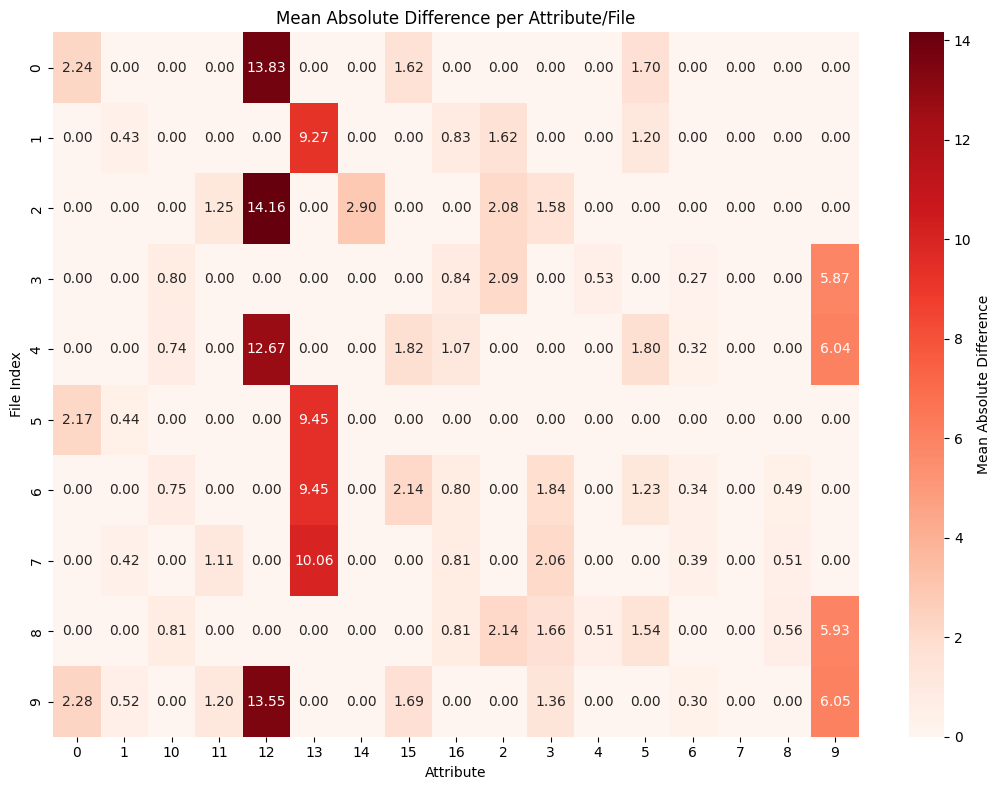

In [413]:
# Prepare a DataFrame to hold mean absolute differences
diff_matrix = pd.DataFrame(index=range(10), columns=all_attrs, dtype=float)

for file_idx in range(10):
    for attr in all_attrs:
        pure_vals = []
        fcm_vals = []

        num_rows = len(pureKNN_imputed[file_idx])
        for row_idx in range(num_rows):
            val1 = pureKNN_imputed[file_idx][row_idx].get(attr, np.nan)
            val2 = fcmKNN_imputed[file_idx][row_idx].get(attr, np.nan)

            if not (val1 != val1 or val2 != val2):  # check for NaN
                pure_vals.append(val1)
                fcm_vals.append(val2)

        if pure_vals and fcm_vals:
            diffs = np.abs(np.array(pure_vals) - np.array(fcm_vals))
            mean_diff = diffs.mean()
        else:
            mean_diff = np.nan

        diff_matrix.at[file_idx, attr] = mean_diff

plt.figure(figsize=(len(all_attrs)*0.4 + 4, 8))
sns.heatmap(diff_matrix, annot=True, fmt=".2f", cmap="Reds", cbar_kws={'label': 'Mean Absolute Difference'})

plt.title("Mean Absolute Difference per Attribute/File")
plt.xlabel("Attribute")
plt.ylabel("File Index")
plt.tight_layout()
plt.show()
